In [1]:
import pandas as pd
import numpy as np
from numba import jit
import torch
import time, math
from matplotlib import pyplot

In [2]:
apple_df = pd.read_csv("./data/yahoo/AAPL.csv")
apple_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296661,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916723,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008965,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887323,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994268,258529600


## Feature engineering

### Change in Percent

In [3]:
features = [column for column in apple_df.columns if column not in ['Date', 'Adj Close']]
label_feature = ['Adj Close']

@jit(nopython=True)
def calc_percent_diff(new_value, old_value):
    diff = abs(new_value - old_value)
    sum = new_value + old_value
    return diff / (sum / 2) * 100

@jit(nopython=True)
def get_percent_change(*features):
    res = np.empty((len(features), features[0].shape[0]))
    res[:, 0] = [feature[0] for feature in features]
    for i in range(1, res.shape[1]):
        res[:, i] = [calc_percent_diff(feature[i], feature[i - 1]) for feature in features]
    return res

In [4]:
percent_change = get_percent_change(*apple_df[features].values.T)

In [5]:
d = {features[i]: percent_change[i] for i in range(len(features))}
res_df = pd.DataFrame(data=d)
res_df[label_feature] = apple_df[label_feature]
## remove first row
res_df = res_df.iloc[1:]
res_df.head()

,Open,High,Low,Close,Volume,Adj Close
1,0.508774,0.599607,2.121838,2.220978,50.317212,16.916723
2,2.826722,1.253980,1.271847,0.543819,5.004034,17.008965
3,1.270142,0.153733,0.806340,0.717726,26.143871,16.887323
4,1.017428,0.073294,0.143042,0.631287,20.384105,16.994268
5,1.471980,0.238004,0.621960,1.285214,7.669715,16.777260


### Train, Test, Validation Split
60%, 20%, 20% split

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(res_df, test_size=0.2, random_state=1, shuffle=False)

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1, shuffle=False) # 0.25 x 0.8 = 0.2

In [7]:
train_data.shape

(1528, 6)

In [8]:
test_data.shape

(510, 6)

In [9]:
val_data.shape

(510, 6)

### Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
norm_train = scaler.fit_transform(train_data)
norm_val = scaler.transform(val_data)
norm_test = scaler.transform(test_data)

### Preprocessing

In [11]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_len = input_window_size + output_window_size
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(np.array(inout_seq))

In [12]:
input_window_size = 30 # window size of an input
output_window_size = 1 # window size of an output

norm_train_seq = create_inout_sequences(norm_train, input_window_size, output_window_size)
norm_val_seq = create_inout_sequences(norm_val, input_window_size, output_window_size)
norm_test_seq = create_inout_sequences(norm_test, input_window_size, output_window_size)

In [13]:
norm_train_seq.shape # block_size, 2 (input, output), seq_len, num_features

torch.Size([1498, 2, 30, 6])

In [14]:
norm_val_seq.shape

torch.Size([480, 2, 30, 6])

In [15]:
norm_test_seq.shape

torch.Size([480, 2, 30, 6])

## Model
This model predicts the closed price in the future :)

In [16]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
          

class TransAm(nn.Module):
    def __init__(self, input_feature_num, output_feature_num, pos_feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(input_feature_num, pos_feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(pos_feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=pos_feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(pos_feature_size, output_feature_num)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [17]:
def get_batch(input_data, i , batch_size):
    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((-1,batch_len,6))
    # ( seq_len, batch, 6 ) , 6 is feature size
    target = torch.stack([item[1] for item in data]).view((-1,batch_len,6))
    return input, target
    
def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [18]:
def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1, :, -1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1, :, -1].view(-1).cpu()), 0)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


# predict the next n steps based on the input data 
def predict_future(eval_model, data_source, steps, input_window):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source, 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)

    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")    
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.show()
    pyplot.close()
        

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

/home/jaewookahn/miniconda3/envs/port_comp/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


| epoch   1 |    29/  149 batches | lr 0.005000 |  8.15 ms | loss 1.29714 | ppl     3.66
| epoch   1 |    58/  149 batches | lr 0.005000 |  2.65 ms | loss 0.13565 | ppl     1.15
| epoch   1 |    87/  149 batches | lr 0.005000 |  2.82 ms | loss 0.10310 | ppl     1.11
| epoch   1 |   116/  149 batches | lr 0.005000 |  2.94 ms | loss 0.09683 | ppl     1.10
| epoch   1 |   145/  149 batches | lr 0.005000 |  2.39 ms | loss 0.08792 | ppl     1.09
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.58s | valid loss 1.58048 | valid ppl     4.86
-----------------------------------------------------------------------------------------
| epoch   2 |    29/  149 batches | lr 0.004513 |  2.49 ms | loss 0.08227 | ppl     1.09
| epoch   2 |    58/  149 batches | lr 0.004513 |  2.44 ms | loss 0.06929 | ppl     1.07
| epoch   2 |    87/  149 batches | lr 0.004513 |  2.34 ms | loss 0.06821 | ppl     1.07
| epoch   2 |   116/  149 batche

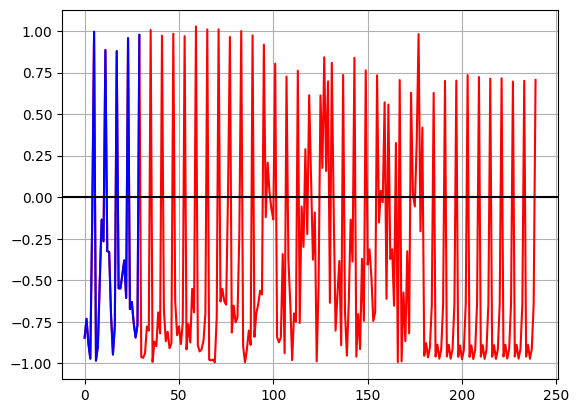

-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  0.92s | valid loss 0.51076 | valid ppl     1.67
-----------------------------------------------------------------------------------------
| epoch   6 |    29/  149 batches | lr 0.003675 |  2.74 ms | loss 0.04411 | ppl     1.05
| epoch   6 |    58/  149 batches | lr 0.003675 |  2.88 ms | loss 0.04259 | ppl     1.04
| epoch   6 |    87/  149 batches | lr 0.003675 |  2.39 ms | loss 0.04377 | ppl     1.04
| epoch   6 |   116/  149 batches | lr 0.003675 |  2.86 ms | loss 0.04149 | ppl     1.04
| epoch   6 |   145/  149 batches | lr 0.003675 |  3.15 ms | loss 0.04303 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  0.43s | valid loss 0.50207 | valid ppl     1.65
-----------------------------------------------------------------------------------------
| epoch   7 |    29/  149 batches | lr 0.00

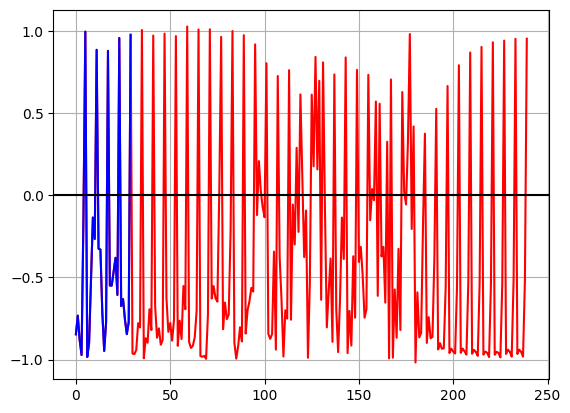

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  0.87s | valid loss 0.43633 | valid ppl     1.55
-----------------------------------------------------------------------------------------
| epoch  11 |    29/  149 batches | lr 0.002844 |  2.61 ms | loss 0.04168 | ppl     1.04
| epoch  11 |    58/  149 batches | lr 0.002844 |  2.72 ms | loss 0.03691 | ppl     1.04
| epoch  11 |    87/  149 batches | lr 0.002844 |  2.61 ms | loss 0.04250 | ppl     1.04
| epoch  11 |   116/  149 batches | lr 0.002844 |  2.27 ms | loss 0.03824 | ppl     1.04
| epoch  11 |   145/  149 batches | lr 0.002844 |  2.86 ms | loss 0.03922 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  0.40s | valid loss 0.43038 | valid ppl     1.54
-----------------------------------------------------------------------------------------
| epoch  12 |    29/  149 batches | lr 0.00

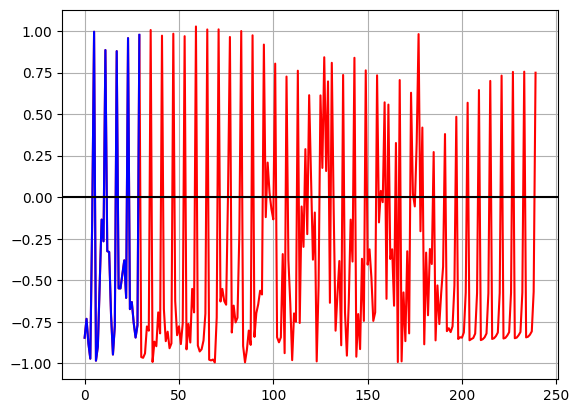

-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  0.86s | valid loss 0.45842 | valid ppl     1.58
-----------------------------------------------------------------------------------------
| epoch  16 |    29/  149 batches | lr 0.002201 |  2.64 ms | loss 0.04107 | ppl     1.04
| epoch  16 |    58/  149 batches | lr 0.002201 |  2.34 ms | loss 0.03988 | ppl     1.04
| epoch  16 |    87/  149 batches | lr 0.002201 |  2.33 ms | loss 0.03812 | ppl     1.04
| epoch  16 |   116/  149 batches | lr 0.002201 |  2.19 ms | loss 0.03722 | ppl     1.04
| epoch  16 |   145/  149 batches | lr 0.002201 |  2.25 ms | loss 0.03840 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  0.36s | valid loss 0.50598 | valid ppl     1.66
-----------------------------------------------------------------------------------------
| epoch  17 |    29/  149 batches | lr 0.00

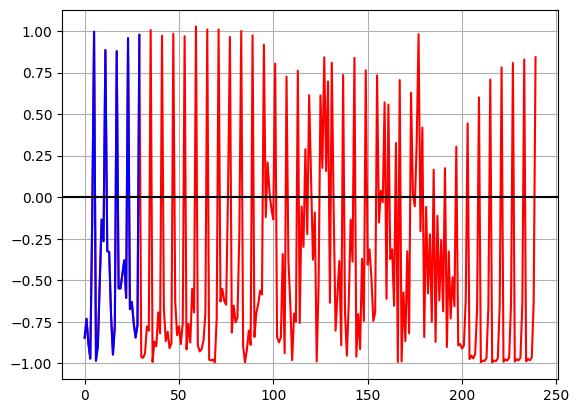

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  0.80s | valid loss 0.40639 | valid ppl     1.50
-----------------------------------------------------------------------------------------
| epoch  21 |    29/  149 batches | lr 0.001703 |  2.48 ms | loss 0.03844 | ppl     1.04
| epoch  21 |    58/  149 batches | lr 0.001703 |  2.34 ms | loss 0.03696 | ppl     1.04
| epoch  21 |    87/  149 batches | lr 0.001703 |  2.31 ms | loss 0.03762 | ppl     1.04
| epoch  21 |   116/  149 batches | lr 0.001703 |  2.39 ms | loss 0.03737 | ppl     1.04
| epoch  21 |   145/  149 batches | lr 0.001703 |  2.23 ms | loss 0.03641 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  0.36s | valid loss 0.41842 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  22 |    29/  149 batches | lr 0.00

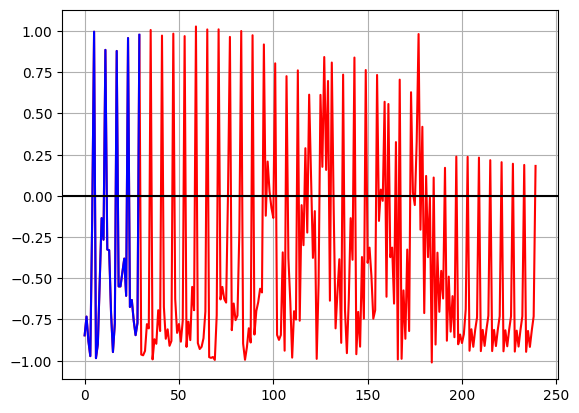

-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  0.83s | valid loss 0.41853 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  26 |    29/  149 batches | lr 0.001318 |  2.53 ms | loss 0.03573 | ppl     1.04
| epoch  26 |    58/  149 batches | lr 0.001318 |  2.37 ms | loss 0.03521 | ppl     1.04
| epoch  26 |    87/  149 batches | lr 0.001318 |  2.50 ms | loss 0.03687 | ppl     1.04
| epoch  26 |   116/  149 batches | lr 0.001318 |  2.41 ms | loss 0.03519 | ppl     1.04
| epoch  26 |   145/  149 batches | lr 0.001318 |  2.28 ms | loss 0.03640 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  0.37s | valid loss 0.39762 | valid ppl     1.49
-----------------------------------------------------------------------------------------
| epoch  27 |    29/  149 batches | lr 0.00

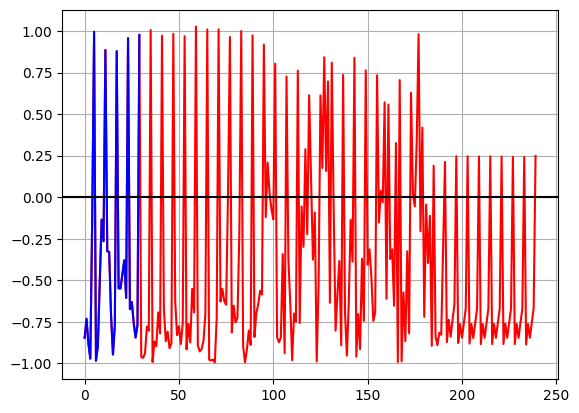

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  1.06s | valid loss 0.40456 | valid ppl     1.50
-----------------------------------------------------------------------------------------
| epoch  31 |    29/  149 batches | lr 0.001020 |  2.60 ms | loss 0.03516 | ppl     1.04
| epoch  31 |    58/  149 batches | lr 0.001020 |  2.88 ms | loss 0.03457 | ppl     1.04
| epoch  31 |    87/  149 batches | lr 0.001020 |  2.92 ms | loss 0.03299 | ppl     1.03
| epoch  31 |   116/  149 batches | lr 0.001020 |  2.41 ms | loss 0.03437 | ppl     1.03
| epoch  31 |   145/  149 batches | lr 0.001020 |  3.11 ms | loss 0.03463 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  0.43s | valid loss 0.43760 | valid ppl     1.55
-----------------------------------------------------------------------------------------
| epoch  32 |    29/  149 batches | lr 0.00

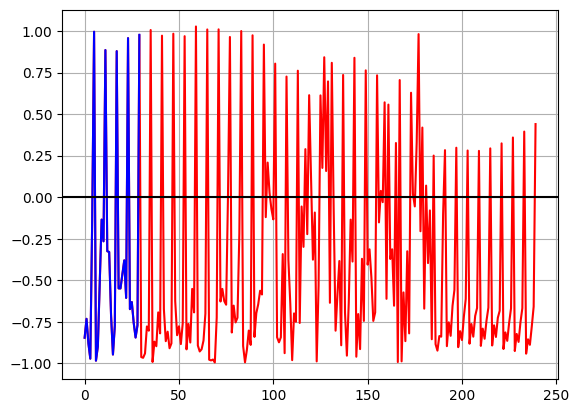

-----------------------------------------------------------------------------------------
| end of epoch  35 | time:  0.98s | valid loss 0.38011 | valid ppl     1.46
-----------------------------------------------------------------------------------------
| epoch  36 |    29/  149 batches | lr 0.000789 |  2.65 ms | loss 0.03232 | ppl     1.03
| epoch  36 |    58/  149 batches | lr 0.000789 |  2.71 ms | loss 0.03183 | ppl     1.03
| epoch  36 |    87/  149 batches | lr 0.000789 |  3.15 ms | loss 0.03215 | ppl     1.03
| epoch  36 |   116/  149 batches | lr 0.000789 |  3.06 ms | loss 0.03276 | ppl     1.03
| epoch  36 |   145/  149 batches | lr 0.000789 |  2.95 ms | loss 0.03175 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  36 | time:  0.44s | valid loss 0.39395 | valid ppl     1.48
-----------------------------------------------------------------------------------------
| epoch  37 |    29/  149 batches | lr 0.00

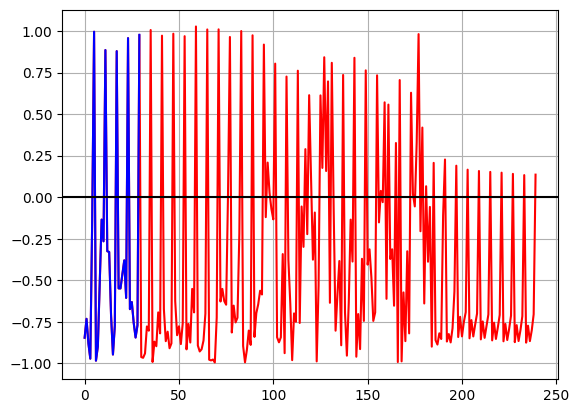

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  0.91s | valid loss 0.41895 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  41 |    29/  149 batches | lr 0.000610 |  2.55 ms | loss 0.03216 | ppl     1.03
| epoch  41 |    58/  149 batches | lr 0.000610 |  2.70 ms | loss 0.03110 | ppl     1.03
| epoch  41 |    87/  149 batches | lr 0.000610 |  2.91 ms | loss 0.03009 | ppl     1.03
| epoch  41 |   116/  149 batches | lr 0.000610 |  2.39 ms | loss 0.02906 | ppl     1.03
| epoch  41 |   145/  149 batches | lr 0.000610 |  2.85 ms | loss 0.02930 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  0.41s | valid loss 0.39227 | valid ppl     1.48
-----------------------------------------------------------------------------------------
| epoch  42 |    29/  149 batches | lr 0.00

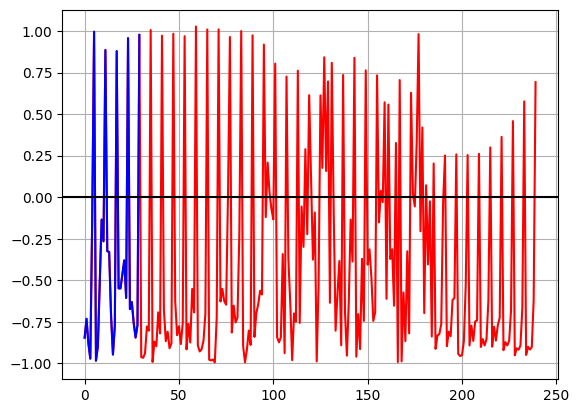

-----------------------------------------------------------------------------------------
| end of epoch  45 | time:  0.89s | valid loss 0.40896 | valid ppl     1.51
-----------------------------------------------------------------------------------------
| epoch  46 |    29/  149 batches | lr 0.000472 |  2.59 ms | loss 0.02970 | ppl     1.03
| epoch  46 |    58/  149 batches | lr 0.000472 |  2.74 ms | loss 0.02932 | ppl     1.03
| epoch  46 |    87/  149 batches | lr 0.000472 |  2.36 ms | loss 0.02936 | ppl     1.03
| epoch  46 |   116/  149 batches | lr 0.000472 |  2.97 ms | loss 0.02879 | ppl     1.03
| epoch  46 |   145/  149 batches | lr 0.000472 |  2.93 ms | loss 0.02698 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  46 | time:  0.42s | valid loss 0.43130 | valid ppl     1.54
-----------------------------------------------------------------------------------------
| epoch  47 |    29/  149 batches | lr 0.00

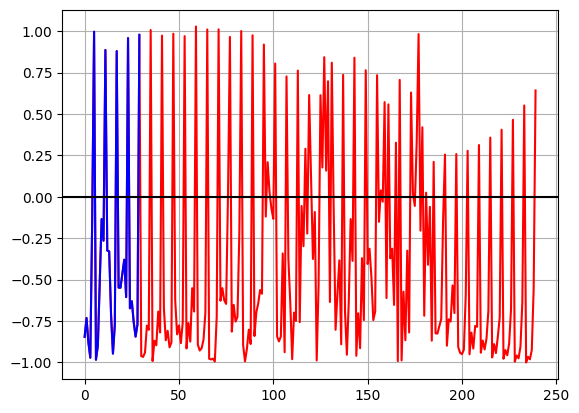

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  0.89s | valid loss 0.40422 | valid ppl     1.50
-----------------------------------------------------------------------------------------
| epoch  51 |    29/  149 batches | lr 0.000365 |  2.61 ms | loss 0.02870 | ppl     1.03
| epoch  51 |    58/  149 batches | lr 0.000365 |  2.32 ms | loss 0.02703 | ppl     1.03
| epoch  51 |    87/  149 batches | lr 0.000365 |  2.64 ms | loss 0.02764 | ppl     1.03
| epoch  51 |   116/  149 batches | lr 0.000365 |  2.26 ms | loss 0.02789 | ppl     1.03
| epoch  51 |   145/  149 batches | lr 0.000365 |  2.40 ms | loss 0.02603 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  0.38s | valid loss 0.39952 | valid ppl     1.49
-----------------------------------------------------------------------------------------
| epoch  52 |    29/  149 batches | lr 0.00

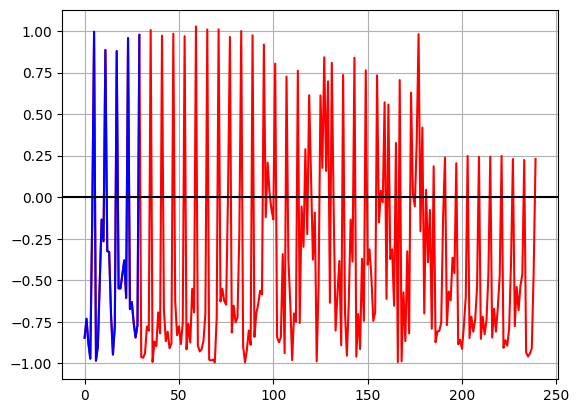

-----------------------------------------------------------------------------------------
| end of epoch  55 | time:  0.94s | valid loss 0.40763 | valid ppl     1.50
-----------------------------------------------------------------------------------------
| epoch  56 |    29/  149 batches | lr 0.000283 |  2.82 ms | loss 0.02711 | ppl     1.03
| epoch  56 |    58/  149 batches | lr 0.000283 |  3.23 ms | loss 0.02633 | ppl     1.03
| epoch  56 |    87/  149 batches | lr 0.000283 |  3.06 ms | loss 0.02594 | ppl     1.03
| epoch  56 |   116/  149 batches | lr 0.000283 |  2.51 ms | loss 0.02682 | ppl     1.03
| epoch  56 |   145/  149 batches | lr 0.000283 |  2.76 ms | loss 0.02614 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  56 | time:  0.44s | valid loss 0.39591 | valid ppl     1.49
-----------------------------------------------------------------------------------------
| epoch  57 |    29/  149 batches | lr 0.00

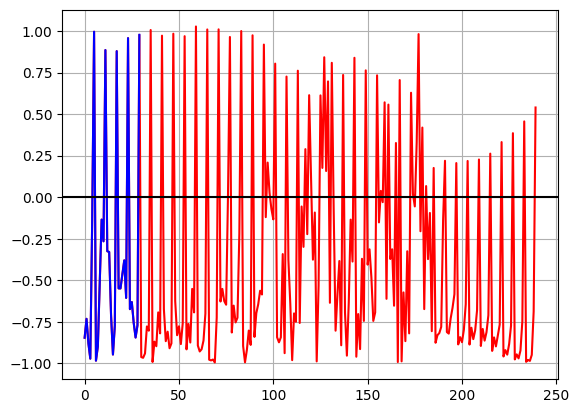

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  0.95s | valid loss 0.40256 | valid ppl     1.50
-----------------------------------------------------------------------------------------
| epoch  61 |    29/  149 batches | lr 0.000219 |  2.85 ms | loss 0.02632 | ppl     1.03
| epoch  61 |    58/  149 batches | lr 0.000219 |  3.01 ms | loss 0.02546 | ppl     1.03
| epoch  61 |    87/  149 batches | lr 0.000219 |  2.97 ms | loss 0.02579 | ppl     1.03
| epoch  61 |   116/  149 batches | lr 0.000219 |  2.48 ms | loss 0.02510 | ppl     1.03
| epoch  61 |   145/  149 batches | lr 0.000219 |  3.07 ms | loss 0.02435 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  0.44s | valid loss 0.41690 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  62 |    29/  149 batches | lr 0.00

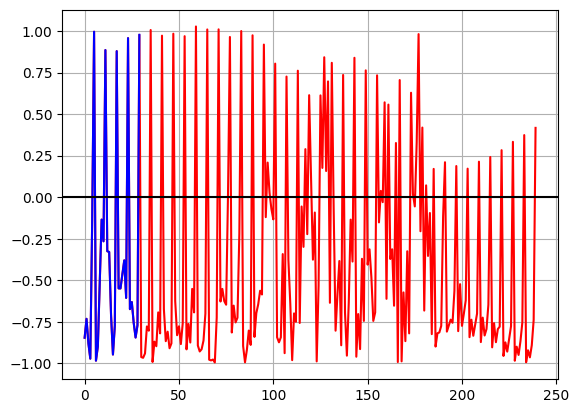

-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  0.96s | valid loss 0.41245 | valid ppl     1.51
-----------------------------------------------------------------------------------------
| epoch  66 |    29/  149 batches | lr 0.000169 |  2.61 ms | loss 0.02511 | ppl     1.03
| epoch  66 |    58/  149 batches | lr 0.000169 |  2.41 ms | loss 0.02457 | ppl     1.02
| epoch  66 |    87/  149 batches | lr 0.000169 |  2.40 ms | loss 0.02438 | ppl     1.02
| epoch  66 |   116/  149 batches | lr 0.000169 |  2.94 ms | loss 0.02494 | ppl     1.03
| epoch  66 |   145/  149 batches | lr 0.000169 |  2.58 ms | loss 0.02416 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  66 | time:  0.40s | valid loss 0.41167 | valid ppl     1.51
-----------------------------------------------------------------------------------------
| epoch  67 |    29/  149 batches | lr 0.00

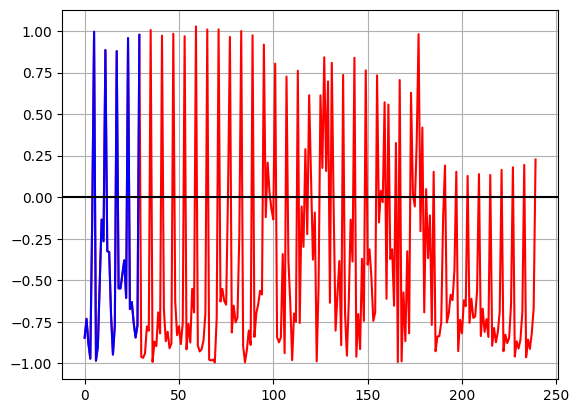

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  1.06s | valid loss 0.42621 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  71 |    29/  149 batches | lr 0.000131 |  2.71 ms | loss 0.02462 | ppl     1.02
| epoch  71 |    58/  149 batches | lr 0.000131 |  2.76 ms | loss 0.02424 | ppl     1.02
| epoch  71 |    87/  149 batches | lr 0.000131 |  2.58 ms | loss 0.02447 | ppl     1.02
| epoch  71 |   116/  149 batches | lr 0.000131 |  2.88 ms | loss 0.02354 | ppl     1.02
| epoch  71 |   145/  149 batches | lr 0.000131 |  2.98 ms | loss 0.02362 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  0.43s | valid loss 0.41519 | valid ppl     1.51
-----------------------------------------------------------------------------------------
| epoch  72 |    29/  149 batches | lr 0.00

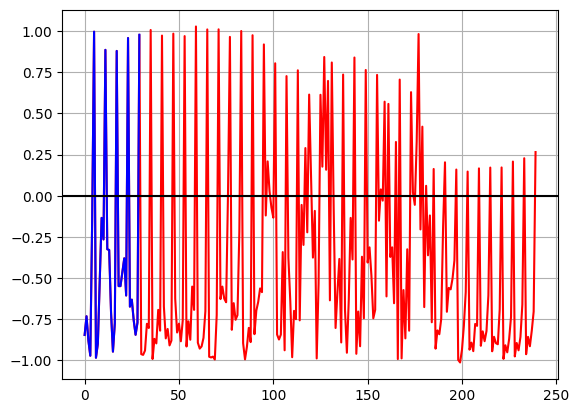

-----------------------------------------------------------------------------------------
| end of epoch  75 | time:  0.95s | valid loss 0.41811 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  76 |    29/  149 batches | lr 0.000101 |  2.77 ms | loss 0.02329 | ppl     1.02
| epoch  76 |    58/  149 batches | lr 0.000101 |  3.17 ms | loss 0.02347 | ppl     1.02
| epoch  76 |    87/  149 batches | lr 0.000101 |  3.01 ms | loss 0.02248 | ppl     1.02
| epoch  76 |   116/  149 batches | lr 0.000101 |  2.85 ms | loss 0.02465 | ppl     1.02
| epoch  76 |   145/  149 batches | lr 0.000101 |  2.92 ms | loss 0.02295 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  0.45s | valid loss 0.42093 | valid ppl     1.52
-----------------------------------------------------------------------------------------
| epoch  77 |    29/  149 batches | lr 0.00

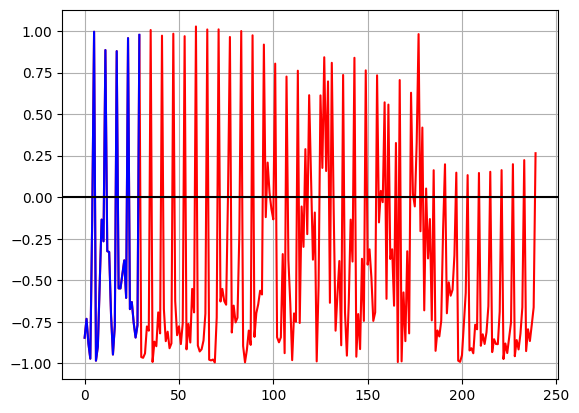

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  0.98s | valid loss 0.42556 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  81 |    29/  149 batches | lr 0.000078 |  2.87 ms | loss 0.02468 | ppl     1.02
| epoch  81 |    58/  149 batches | lr 0.000078 |  2.85 ms | loss 0.02282 | ppl     1.02
| epoch  81 |    87/  149 batches | lr 0.000078 |  2.85 ms | loss 0.02238 | ppl     1.02
| epoch  81 |   116/  149 batches | lr 0.000078 |  2.87 ms | loss 0.02222 | ppl     1.02
| epoch  81 |   145/  149 batches | lr 0.000078 |  2.92 ms | loss 0.02294 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  0.44s | valid loss 0.42380 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  82 |    29/  149 batches | lr 0.00

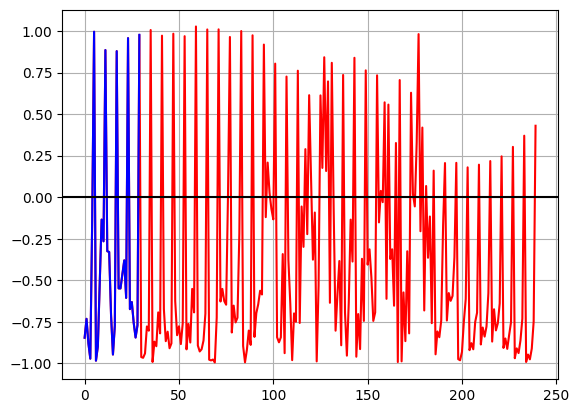

-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  0.94s | valid loss 0.42799 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  86 |    29/  149 batches | lr 0.000061 |  2.66 ms | loss 0.02309 | ppl     1.02
| epoch  86 |    58/  149 batches | lr 0.000061 |  2.64 ms | loss 0.02230 | ppl     1.02
| epoch  86 |    87/  149 batches | lr 0.000061 |  2.79 ms | loss 0.02257 | ppl     1.02
| epoch  86 |   116/  149 batches | lr 0.000061 |  2.68 ms | loss 0.02244 | ppl     1.02
| epoch  86 |   145/  149 batches | lr 0.000061 |  2.88 ms | loss 0.02306 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  86 | time:  0.42s | valid loss 0.42596 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  87 |    29/  149 batches | lr 0.00

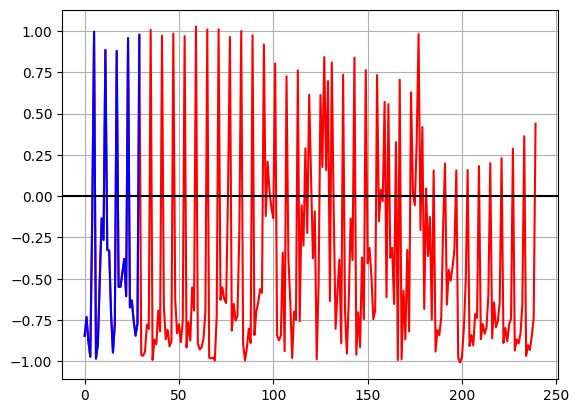

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  0.99s | valid loss 0.42700 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  91 |    29/  149 batches | lr 0.000047 |  2.82 ms | loss 0.02331 | ppl     1.02
| epoch  91 |    58/  149 batches | lr 0.000047 |  2.74 ms | loss 0.02173 | ppl     1.02
| epoch  91 |    87/  149 batches | lr 0.000047 |  2.97 ms | loss 0.02256 | ppl     1.02
| epoch  91 |   116/  149 batches | lr 0.000047 |  3.05 ms | loss 0.02303 | ppl     1.02
| epoch  91 |   145/  149 batches | lr 0.000047 |  2.81 ms | loss 0.02180 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  0.44s | valid loss 0.42848 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  92 |    29/  149 batches | lr 0.00

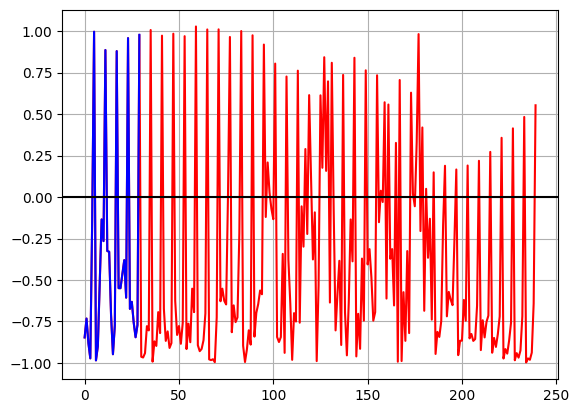

-----------------------------------------------------------------------------------------
| end of epoch  95 | time:  0.98s | valid loss 0.42835 | valid ppl     1.53
-----------------------------------------------------------------------------------------
| epoch  96 |    29/  149 batches | lr 0.000036 |  2.61 ms | loss 0.02231 | ppl     1.02
| epoch  96 |    58/  149 batches | lr 0.000036 |  2.69 ms | loss 0.02215 | ppl     1.02
| epoch  96 |    87/  149 batches | lr 0.000036 |  2.96 ms | loss 0.02206 | ppl     1.02
| epoch  96 |   116/  149 batches | lr 0.000036 |  2.60 ms | loss 0.02284 | ppl     1.02
| epoch  96 |   145/  149 batches | lr 0.000036 |  2.87 ms | loss 0.02221 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  96 | time:  0.42s | valid loss 0.43032 | valid ppl     1.54
-----------------------------------------------------------------------------------------
| epoch  97 |    29/  149 batches | lr 0.00

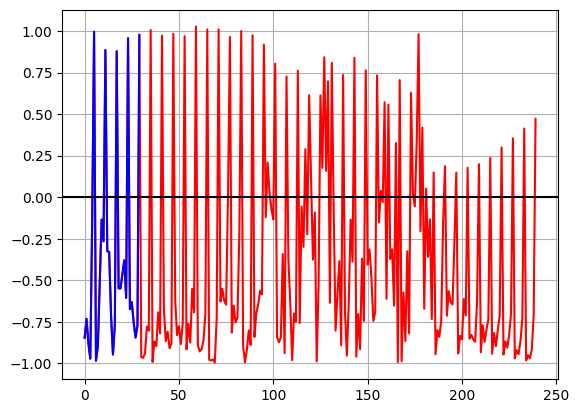

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  0.92s | valid loss 0.43275 | valid ppl     1.54
-----------------------------------------------------------------------------------------


In [20]:
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
day_in_future = 10 # day in the future to predict

model = TransAm(6, 6).to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    idx = torch.randperm(len(norm_train_seq)) # shuffle
    epoch_start_time = time.time()
    train(norm_train_seq[idx].to(device))
    if ( epoch % 5 == 0 ):
        val_loss = plot_and_loss(model, norm_val_seq.to(device), epoch)
        predict_future(model, norm_val_seq.to(device), day_in_future, input_window_size)
    else:
        val_loss = evaluate(model, norm_val_seq.to(device))
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

## Inference
Autoregressive inference

In [ ]:
day_in_future = 10 # day in the future to predict
